## Conceptual introduction

Recommender systems often involve applying some kind of an algorithm to the so called **user-item ratings matrix** of size $NxM$ where $N$ - number of users, $M$ - number of items. This matrix is sparse which is good since our goal is to recommend products to users and it would be nice to have something to recommend in the first place. The optimized implementation involves application of sparse matrices or dictionaries but for the purpose of this notebook I won't use sparse matrices. In real-life scenarios this is absolutely crucial as the full matrix won't fit into memory. For example YouTube is said to have over 1.3 billion users and over 7 billion videos (as of 03.2019) and the user-item matrix size is mindblowing. At the same time each of those users watched only a small fraction of all available videos so it's pointless to store so many missing values in a normal matrix.

The value in a cell could be a rating (eg. on a scale from 1 to 5 - star-based system), whether a user rated an item positively or negatively (thumb-up / thumb-down approach). This type of information is called **explicit** - we know the real attitude of a particular user toward an item. The second type of information used in recommender systems is **implicit** rating - we only know that a user browsed an item, watched a movie, listened to a song etc. - in that case we can't tell if he/she liked it explicitly, we can only assume that. It is often concluded that the more times a user interacted with an item/song/movie the more confidence we have that he/she in fact likes it.

The implementation presented below assumes we only deal with explicit ratings.

| UserId \ ItemId | Item 1 | Item 2 | Item 3 | Item 4 | ... | Item M |
|:---------------:|--------|--------|--------|--------|-----|--------|
| **User 1**          |    2   |    4   |    4   |    3   | ... |   4.5  |
| **User 2**          |   3.5  |    5   |   4.5  |   2.5  | ... |    4   |
| **User 3**          |    1   |    2   |    5   |   1.5  | ... |    5   |
| **...**             |   ...  |   ...  |   ...  |   ...  | ... |   ...  |
| **User N**          |    4   |   3.5  |    4   |   4.5  | ... |   2.5  |

<div style="text-align: center">Example of user-item ratings matrix</div>


In [1]:
import numpy as np
import pandas as pd
import random
import sys
from datetime import datetime
from itertools import product
import matplotlib.pyplot as plt

N_USERS = 5000
N_MOVIES = 1000

# Data

As the main goal of this notebook is to explain the intuition behind the most common algorithms related to recommender systems and by no means the efficiency of implementation, the dataset size is small and the algorithm itself could be further optimized (I vectorized the code where possible though). It is based on the well-known movielens dataset available [here](https://grouplens.org/datasets/movielens/) (Analysis was perofrmed on the 20M records version). The dataset was filtered to include only the most popular movies (top 1000) and the most active users (5000 users). Thus the dimensionality of user-item matrix is $5000x1000$ but the algorithm would work equally on larger dataset as well (at the cost of longer training time).

In [ ]:
all_ratings = pd.read_csv('/home/kuba/Desktop/colab_filt_data/rating.csv', usecols=[0,1,2])

# calculate 1000 most popular movies
mov_chosen = all_ratings.groupby('movieId')['userId'].nunique().sort_values()
mov_chosen = mov_chosen.iloc[-N_MOVIES:].index.values

# calculate top 5000 users who rated the most movies
user_chosen = all_ratings.groupby('userId')['movieId'].nunique().sort_values()
user_chosen = user_chosen.iloc[-N_USERS:].index.values

# filter a data frame to the cohsen movies and users
# we need to call copy() method, because selecting rows from dataframe
# only creates a view of original df hence we have to make a new df by calling copy()
ratings = all_ratings[all_ratings.userId.isin(user_chosen) & all_ratings.movieId.isin(mov_chosen)].copy()
del all_ratings

# save the filtered data frame
ratings.to_csv('/home/kuba/Desktop/colab_filt_data/ratings_filtered.csv', index=False)

Now that we have a dataset ready, we will split it into training and test sets (train-test split = 0.7).

In [2]:
ratings = pd.read_csv("./ratings_filtered.csv") #("/home/kuba/Desktop/colab_filt_data/new_ramka.csv")
random.seed(2019)

# train-test-split: 70% split
orig_ind = ratings.index.tolist()
tr_ind = random.sample(orig_ind, int(0.7*ratings.shape[0]), )

X_train = ratings.loc[tr_ind, :]
X_test = ratings.loc[list(set(orig_ind)-set(tr_ind)), :]

# what the training data look like?
print("We have ", X_train.shape[0], " distinct ratings in the training set.")
X_train.head()

We have  1647602  distinct ratings in the training set.


,userId,movieId,rating
648382,37319,5266,3.0
1016091,59407,8376,2.5
2085030,122178,1387,3.5
673590,38899,2717,3.5
1028128,60020,1199,4.5


The next step is to convert the existing dataframe to a $NxM$ ratings matrix.

In [3]:
R_mat = X_train.pivot(index = 'userId', columns = 'movieId', values = 'rating')

# we use a fact that pivot sorts indexes to create a mapping for movies and users
user_map = dict(zip(range(N_USERS), R_mat.index.values))
movies_map = dict(zip(range(N_MOVIES), R_mat.columns.values))
user_map_rev = {v: k for k, v in user_map.items()}
movies_map_rev = {v: k for k, v in movies_map.items()}

# create numpy array - we could use scipy sparse matrices in case of larger matrix size
R_mat = R_mat.values.astype(np.float64)
#R_mat_orig = R_mat.copy()

print("The most active user watched", max(np.count_nonzero(~np.isnan(R_mat), 1)),
      "out of", N_MOVIES, "most popular movies.")
print("The most popular movie was watched by", max(np.count_nonzero(~np.isnan(R_mat), 0)),
      "out of", N_USERS, "most active users.")

The most active user watched 725 out of 1000 most popular movies.
The most popular movie was watched by 3322 out of 5000 most active users.


## Collaborative filtering

On a high level the main goal of collaborative filtering is to predict what rating would user $i$ give to item $j$. Let's call the prediction $\hat{r}(i,j)$ and the actual rating $r(i,j)$. Then we need to calculate mean squared error with a formula:
$$MSE = \frac{1}{|\Omega|}\sum_{i,j \in \Omega} (r_{ij} - \hat{r}_{ij})^2$$
, where $\Omega$ is a set of all non-missing user-item rating pairs.

Diving deeper, we need to calculate a set of similar users for each one of the users (by calculating correlation of ratings for each pair of users). Intuitively we should pay more attention to ratings of users who are more similar to a given user. When calculating a prediction for user $i$ and item $j$ we take into consideration the ratings given to item $j$ by all users who rated it (denoted by $\Omega_j$) and weighting the result with a correlation factor between users (denoted by $w_{ii'}$) which we want to be high for similar users and low for dissimilar users:
$$\hat{r}(i,j) = \frac{\sum_{i\prime \in \Omega_j} w_{ii\prime}r_{i\prime j}}{\sum_{i\prime \in \Omega_j} w_{ii\prime}}$$


The other thing we need to care about is a naturally existing bias in ratings - there are users whose average rating is high (it's easy to make them happy) and very picky users (who rarely give high ratings and are generally hard to please). We need to accomodate for this fact by analyzing relative ratings. It is achieved by subtracting the mean rating of each user $i$ (denoted by $\overline{r}_i$) from his/her ratings.

In [4]:
# calculate average ratings for each user
mean_ratings = np.nanmean(R_mat, axis=1).reshape(-1,1)
print("The most demanding user's average rating:", np.round(min(mean_ratings)[0], 2))
print("The least demanding user's average rating:", np.round(max(mean_ratings)[0], 2))

# Subtract average ratings from known ratings.
# We are interested in deviations of ratings from what is an average rating of a user.
R_mat -= mean_ratings

The most demanding user's average rating: 1.23
The least demanding user's average rating: 4.89


We subtracted the average rating of each user from his/her known ratings. When making a prediction we need to account for this fact as well and the final prediction will be calculated as a sum of a given user's average rating ($\overline{r}_i$ part) and the sum of deviations ($r_{i\prime j}-\overline{r}_{i\prime}$ part) in ratings of item $j$ given by each user $i\prime$ who rated item $j$ ($\Omega_j$ set) weighted by similarity of all pairs of users $(i, i\prime)$ - $w_{i,i\prime} $ coefficients.
$$\hat{r}(i,j) = \overline{r}_i + \frac{\sum_{i\prime \in \Omega_j} w_{i,i\prime}(r_{i\prime j}-\overline{r}_{i\prime})}{\sum_{i\prime \in \Omega_j} |w_{i,i\prime}|} $$

The intuition behind this equation is that we need to add to our bias (how in general we rate items) the averaged differences between a rating of item $j$ that a user $i\prime$ gave and his/her bias. If a user $i\prime$ likes an item $j$ very much in comparison to his normal ratings and in addition he/she is very similar to us (large $w_{i,i\prime}$ coefficient) he/she will influence our score greatly.

The final question arises - how do we compute correlation between users? We need to calculate ${N\choose 2}$ pairs of correlations since $corr(i,i\prime)=corr(i\prime,i)$. It is a simple Pearson correlation but restricted to data we have:
$$w_{i,i\prime} = \frac{\sum_{j \in \Omega_{i,i\prime}} (r_{ij}-\overline{r}_i)(r_{i\prime j}-\overline{r}_{i\prime})}{\sqrt{\sum_{j \in \Omega_i} (r_{ij}-\overline{r}_i)^2} \sqrt{\sum_{j \in \Omega_{i\prime}} (r_{i\prime j}-\overline{r}_{i\prime})^2}}$$, where:
* $\Omega_{i,i\prime}$ - set of items that both user $i$ and $i\prime$ have rated
* $\Omega_i$ - set of items that user $i$ has rated

In [37]:
# calculating Pearson correlactions between each pair of users
us_range = range(N_USERS)
weights = np.empty((N_USERS, N_USERS))

all_pairs = list(product(us_range, us_range))
# let's filter out the pairs to cut in half computation time (because of corr(x,y)=corr(y,x))
all_pairs = [(x[0], x[1]) for x in all_pairs if x[0]>=x[1]]

# instead of argwhere we could have created dicts: user2movie, movie2user, usermovie2rating
# in order to lower computation time
# looping through an array is O(N^2), looping through dict is O(|omega|), omega is set of all ratings
t1 = datetime.now()
for p1, p2 in all_pairs:
    # which movies have both users watched?
    mov1 = np.argwhere(~np.isnan(R_mat[p1, :]))
    u1 = R_mat[p1, mov1]
    mov2 = np.argwhere(~np.isnan(R_mat[p2, :]))
    u2 = R_mat[p2, mov2]
    mov_both = np.intersect1d(mov1, mov2)
    u_both = R_mat[np.array([p1,p2])[:,None], mov_both]

    # numerator
    num = np.sum(u_both[0,:]*u_both[1,:])
    # denominator
    den = np.sqrt((u1**2).sum()) * np.sqrt((u2**2).sum())
    sim = num / den
    weights[p1, p2] = sim
    
    if p1 % 100==0 and p2==0:
        print("Starting index", p1, "- previous took", datetime.now()-t1)
        t1 = datetime.now()

# populate upper triangular matrix with transposition of lower triangular matrix
i_upper = np.triu_indices(N_USERS, -1)
weights[i_upper] = weights.T[i_upper]

# sanity checks:
print(weights[15, 15]) # must be equal to 1, since corr(x,x)=1
print(weights[10, 15] == weights[15, 10]) # must return True, since corr(x,y)=corr(y,x)

# save the weights for prediction
np.save('./weights', weights)

doing shit
Starting index 0 - previous took 0:00:00.003488
Starting index 100 - previous took 0:00:00.668562
Starting index 200 - previous took 0:00:01.997038
Starting index 300 - previous took 0:00:03.331714
Starting index 400 - previous took 0:00:04.738789
Starting index 500 - previous took 0:00:05.992617
Starting index 600 - previous took 0:00:07.382275
Starting index 700 - previous took 0:00:08.565068
Starting index 800 - previous took 0:00:09.990160
Starting index 900 - previous took 0:00:11.236932
Starting index 1000 - previous took 0:00:12.534618
Starting index 1100 - previous took 0:00:13.726644
Starting index 1200 - previous took 0:00:14.964427
Starting index 1300 - previous took 0:00:17.759136
Starting index 1400 - previous took 0:00:22.295429
Starting index 1500 - previous took 0:00:35.640279
Starting index 1600 - previous took 0:00:25.288003
Starting index 1700 - previous took 0:00:21.772885
Starting index 1800 - previous took 0:00:22.605239
Starting index 1900 - previous t

In [6]:
weights = np.load("./weights.npy")

# select K top neighbors for each user
#N_NEIGH = 50
#neigh = {}
#for user in weights.index:
#    neigh[user] = weights.loc[user].sort_values(ascending=False).loc[:N_NEIGH]


# PREDICTION
def predict(i=10, j=23):
    who_watched = np.argwhere(~np.isnan(R_mat[:, j]))
    numer = (weights[i, who_watched].reshape(-1,1) * (R_mat[who_watched, j])).sum()
    denom = (np.abs(weights[i, who_watched])).sum()
    s_ij = mean_ratings[i] + numer / denom
    # round extreme results so the range of ratings is <0.5;5>
    s_ij = min(5, s_ij)
    s_ij = max(0.5, s_ij)
    return s_ij

# test
#predict(i=0, j=0)

# defining MSE function
def MSE(true, pred):
    return np.sum(np.subtract(true, pred)**2) / len(pred)


# calculating MSE on train set, which pairs to choose?
train_pred_pairs = []
for ind, row in X_train.iterrows():
    tmp = (user_map_rev[row['userId']], movies_map_rev[row['movieId']])
    train_pred_pairs.append(tmp)

# calculate score for train set, for 50k ratings only, I had some OutOfMemory errors on my laptop
train_scores = np.array([predict(x, y) for x, y in train_pred_pairs[:50000]]).reshape(-1,1)
true_train = np.array(X_train['rating'].values.reshape(-1,1)[:50000])
train_MSE = MSE(true_train, train_scores)
print("Train MSE:", train_MSE[0])

# calculating MSE on test set
test_pred_pairs = []
for ind, row in X_test.iterrows():
    tmp = (user_map_rev[row['userId']], movies_map_rev[row['movieId']])
    test_pred_pairs.append(tmp)

test_scores = np.array([predict(x, y) for x, y in test_pred_pairs[:50000]]).reshape(-1,1)
true_test = np.array(X_test['rating'].values.reshape(-1,1)[:50000])
test_MSE = MSE(true_test, test_scores)
print("Test MSE:", test_MSE[0])

Train MSE: 0.594078171940206
Test MSE: 0.6304054522802464


## Matrix factorization

Another algorithm widely used in a domain of recommender systems is matrix factorization. It is still applied on the same user-item ratings matrix as presented in case of collaborative filtering ($N$ users and $M$ items). The goal is to find two matrices $W$ and $U$ whose dot product yields the initial user-item matrix
$$R=WU^T$$
, with the following dimensionalities:
* $R$ is of shape $NxM$
* $W$ is of shape $NxK$
* $U$ is of shape $MxK$

However it is only possible the get the exact same matrix if $K=N$. In practice $K$ ranges from 10 to 50 and we get the best possible approximation of matrix $R$.
$$\hat{R} \approx WU^T$$

$K$ is a number of hidden factors, features that explain differences between items. In case of movies these could represent for example whether a movie:
* is comedy, drama or horror
* is black and white
* features a specific actor, etc.

We can identify these features by analyzing the items which score particularly high/low for a given feature.

We should at all cost refrain from multiplying full matrices $W$ and $U$ when making prediction because we only need one row and one column in order to predict:
$$\hat{r}_{ij} = w_i^Tu_j$$
The intuition behind this equation is the following: the product of two vectors $w_i$ and $u_j$ tells us how much user's $i$ preferences correlate with item's $j$ attributes. Let's pretend we have 5 hidden features: $K=5$ which can mean for example:
* feature 1: Is di Caprio in the cast?
* feature 2: Did the movie get any Oscars?
* feature 3: Are there any superheroes involved?
* feature 4: Is it a comedy?
* feature 5: Is there a thread about romance?

Our user $i$ has preferences which are described by vector $w_i = [1, 0.7, -0.9, 0.2, 1]$. This user watched movies *Titanic* and *Iron Man* whose attributes are described by vectors $u_{titanic}=[0.9, 1.7, -1.1, 0, 1.3]$ and $u_{ironman}=[-0.9, -1, 1, 0, -0.8]$ respectively.

In [7]:
usr = np.array([1, 0.7, -0.9, 0.2, 1])
mov_titanic = np.array([0.9, 1.7, -1.1, 0, 1.3])
mov_ironman = np.array([-0.9, -1, 1, 0, -0.8])

print("User i will probably like Titanic because the score is", np.round(usr.dot(mov_titanic), 1))
print("User i will probably dislike Iron Man because the score is", np.round(usr.dot(mov_ironman), 1))


User i will probably like Titanic because the score is 4.4
User i will probably dislike Iron Man because the score is -3.3


The question is how to calculate matrices $W$ and $U$? We want to minimize differences between elements of matrix $R$ and $\hat{R}$ which gives us the following cost function:
$$J = \sum_{i,j \in \Omega} (r_{ij} - \hat{r}_{ij})^2 =  \sum_{i,j \in \Omega} (r_{ij} - w_i^Tu_j)^2$$
, where $\Omega_{ij}$ is a set of all pairs where user $i$ rated a movie $j$.

Similarly to collaborative filtering we need to include a user as well as a movie bias - there are users who generally rate movies high/low and there are movies which are generally liked/disliked. The user bias will be denoted as $b_i$ and movie bias as $c_j$:
$$\hat{r}_{ij} = w_i^Tu_j+b_i+c_j$$
The final cost function to optimize is thus equal to:
$$J = \sum_{i,j \in \Omega} (r_{ij} - w_i^Tu_j - b_i - c_j)^2$$

In order to find a minimum of such a function we take a derivative of $J$ with respect to our parameters which in this case are elements of matrices $w_i$ and $u_j$. The derivation of $w_i$ is calculated as follows:
$$\frac{\partial J}{\partial w_i} = 2\sum_{j \in \Omega_i} (r_{ij} - w_i^Tu_j - b_i - c_j)(-u_j)=0$$
, where $j \in \Omega_i$ signifies a set of all movies $j$ that user $i$ has watched since elements of $w_i$ depend only on those values.
$$\sum_{j \in \Omega_i}(w_i^Tu_j)u_j=\sum_{j \in \Omega_i}(r_{ij}-b_i -c_j )u_j$$
The dot product of vectors is commutative (i.e. $a\cdot b=b\cdot a$) so we can further transform the equation:
$$\sum_{j \in \Omega_i}(u_j^Tw_i)u_j=\sum_{j \in \Omega_i}(r_{ij}-b_i -c_j )u_j$$
The expression on the left-hand side in parenthesis is a scalar and since $scalar \cdot vector = vector \cdot scalar$ we have:
$$\sum_{j \in \Omega_i}u_j(u_j^Tw_i)=\sum_{j \in \Omega_i}(r_{ij}-b_i -c_j )u_j$$
On the left-hand side the $w_i$ factor doesn't depend on the summation index $j$ so we simplify:
$$(\sum_{j \in \Omega_i}u_ju_j^T)w_i=\sum_{j \in \Omega_i}(r_{ij}-b_i -c_j )u_j$$

Now all it takes to calculate $w_i$ is to multiply both sides by the inverse of $\sum_{j \in \Omega_i}u_ju_j^T$ and the result is:
$$w_i=(\sum_{j \in \Omega_i}u_ju_j^T)^{-1}\sum_{j \in \Omega_i}(r_{ij}-b_i -c_j )u_j$$

Similar derivation may be performed for updates of vectors $u_j$, $b_i$ and $c_j$.

As $w_i$ depends on $u_j$ and vice versa the optimization of such a function may be achieved with **Alternating Least Squares (ALS)**. The name of a method comes from the fact that we will update parameters of $U$ and $W$ in turns (alternate between updates). 

Additionally we can add regularization to prevent overfitting by adding a penalty to the cost function for large parameters' values. The penalty term will be equal to:
$$\lambda (\|W\|^2+\|U\|^2+\|b\|^2+\|c\|^2)$$
, where $\lambda$ is a regularization hyperparameter.

The final updates of parameters will be equal to:
$$w_i=(\sum_{j \in \Omega_i}u_ju_j^T + \lambda I)^{-1}\sum_{j \in \Omega_i}(r_{ij}-b_i -c_j )u_j$$
$$u_i=(\sum_{i \in \Omega_j}w_iw_i^T + \lambda I)^{-1}\sum_{i \in \Omega_j}(r_{ij}-b_i -c_j )w_i$$
$$b_i=\frac{1}{(1+\lambda)|\Omega_i|} \sum_{j \in \Omega_i} (r_{ij}-w_i^Tu_j-c_j)$$
$$c_j=\frac{1}{(1+\lambda)|\Omega_j|} \sum_{i \in \Omega_j} (r_{ij}-w_i^Tu_j-b_i)$$

In [8]:
# making dictionaries for faster lookup
user2mov = {}
mov2user = {}
usermov2rating = {}

for ind, us in user_map.items():
    user2mov[ind] = [movies_map_rev[x] for x in ratings.loc[ratings.userId==us, 'movieId'].tolist()]

for ind, mo in movies_map.items():
    mov2user[ind] = [user_map_rev[x] for x in ratings.loc[ratings.movieId==mo, 'userId'].tolist()]

for ind, row in ratings.iterrows():
    usermov2rating[(user_map_rev[int(row.userId)], movies_map_rev[int(row.movieId)])] = row.rating
    
print(f'user2mov dict: {np.round(sys.getsizeof(user2mov)/1024**2, 2)} MB occupied')
print(f'mov2user dict: {np.round(sys.getsizeof(mov2user)/1024**2, 2)} MB occupied')
print(f'usermov2rating dict: {np.round(sys.getsizeof(usermov2rating)/1024**2, 2)} MB occupied')

user2mov dict: 0.14 MB occupied
mov2user dict: 0.04 MB occupied
usermov2rating dict: 80.0 MB occupied


In [9]:
# initializing randomly matrices/vectors to optimize
K = 15 
W = np.random.randn(N_USERS, K)
b = np.random.randn(N_USERS, 1)
U = np.random.randn(N_MOVIES, K)
c = np.random.randn(N_MOVIES, 1)
miu = ratings.rating.mean() # centering of data, change for X_train only in the future

As it's hard to fully vectorize calculation of loss function let's create an auxiliary dictionary which for a movie will return a list of pairs (user, rating) giving us all users who watched and rated a given movie. As there are far fewer movies than users, for *for loop* will be calculated much faster.

In [10]:
# create a function to calculate loss
unique_movies = ratings.movieId.unique()
mov2user_rating = {}

for movie in unique_movies:
    tmp = ratings[ratings.movieId == movie]
    usr_rat = (np.asarray([user_map_rev[x] for x in tmp.userId.values]),
               np.asarray(tmp.rating.values))
    mov2user_rating[movies_map_rev[movie]] = usr_rat


In [11]:
# a function takes a dict in the form of: movieId: [(user1, rating1), (user2, rating2), ...]
def calc_loss(mov2ur = mov2user_rating):
    count = 0
    error = 0.
    t1 = datetime.now()
    for mov, info in mov2ur.items():
        user, rat = info
        
        pred = W[user].dot(U[mov]) + b[user].flatten() + c[mov] + miu
        diff = rat - pred
        count += len(rat)
        error += diff.dot(diff)
    return error/count

In [12]:
# ALTERNATING LEAST SQUARES ALGORITHM

K = 15 # setting K - latent dimensionality
LAMBDA = 10 # regularization parameter
N_EPOCHS = 20
train_loss = []
# test_loss = [] # implement in the future

for epoch in range(N_EPOCHS):
    
    # calculate MSE after epoch/20 epochs
    epoch_mse = calc_loss(mov2user_rating)
    train_loss.append(epoch_mse)
    
    t1 = datetime.now()
    # update of W matrix (users)
    for us, us_m in user2mov.items():
        mat = U[us_m].T.dot(U[us_m]) + LAMBDA * np.eye(K)
        us_mov_pairs = list(zip([us]*len(us_m), us_m))
        vec = np.array([(usermov2rating[(x, y)] - b[x] - c[y] - miu)*(U[y].T) for x, y in us_mov_pairs]).sum(0)
        W[us, :] = np.linalg.solve(mat, vec)
        
        # update user bias b
        denom = 1.0 / (len(us_m) + LAMBDA)
        numer = np.sum([usermov2rating[(us, mov)] - W[us].dot(U[mov].T) - c[mov] - miu for mov in us_m])
        b[us] = numer*denom
    
    # update of U matrix (movies)
    for mo, mo_u in mov2user.items():
        mat = W[mo_u].T.dot(W[mo_u]) + LAMBDA * np.eye(K)
        mov_us_pairs = list(zip([mo]*len(mo_u), mo_u))
        vec = np.array([(usermov2rating[(y, x)] - b[y] - c[x] - miu)*(W[y].T) for x, y in mov_us_pairs]).sum(0)
        U[mo, :] = np.linalg.solve(mat, vec)
        
        # update movie bias c
        denom = 1.0 / (len(mo_u) + LAMBDA)
        numer = np.sum([usermov2rating[(us, mo)] - W[us].dot(U[mo].T) - b[us]-miu for us in mo_u])
        c[mo] = numer*denom
    
    print("epoch", epoch, "MSE:", np.round(epoch_mse, 5))
    print("epoch", epoch, "finished in", datetime.now()-t1)

epoch 0 MSE: 17.98201
epoch 0 finished in 0:01:34.735402
epoch 1 MSE: 0.74093
epoch 1 finished in 0:01:39.411124
epoch 2 MSE: 0.52566
epoch 2 finished in 0:01:39.589653
epoch 3 MSE: 0.49493
epoch 3 finished in 0:01:34.344840
epoch 4 MSE: 0.48472
epoch 4 finished in 0:01:32.864324
epoch 5 MSE: 0.48066
epoch 5 finished in 0:01:31.365131
epoch 6 MSE: 0.47862
epoch 6 finished in 0:01:30.565071
epoch 7 MSE: 0.47751
epoch 7 finished in 0:01:30.406181
epoch 8 MSE: 0.47687
epoch 8 finished in 0:01:33.663267
epoch 9 MSE: 0.47648
epoch 9 finished in 0:01:37.379463
epoch 10 MSE: 0.47622
epoch 10 finished in 0:01:42.257707
epoch 11 MSE: 0.47601
epoch 11 finished in 0:01:30.311258
epoch 12 MSE: 0.47582
epoch 12 finished in 0:01:30.141258
epoch 13 MSE: 0.47562
epoch 13 finished in 0:01:30.228012
epoch 14 MSE: 0.47537
epoch 14 finished in 0:01:30.061576
epoch 15 MSE: 0.47504
epoch 15 finished in 0:01:29.990188
epoch 16 MSE: 0.47462
epoch 16 finished in 0:01:29.945473
epoch 17 MSE: 0.47414
epoch 17 fi

Let's plot how the training loss evolved across epochs of training. Before first epoch the MSE was around $18$ (for random weights). MSE decreased with every epoch and after 5th epoch the decrease was tiny. The final MSE settled at $0.47$ which means that on average we are wrong with every prediction by $\sqrt{0.47}=0.68$ stars. One could make easy-to-implement improvements to algorithm by constraining the predictions to range $0.5-5$ and try to round the predictions to the nearest half of rating (e.g. $3.65\approx3.5$) to see whether it improves performance.

The more data we have the better the quality of the algorithm. As the training was done only on the fraction of entire dataset (1.4 million out of 20 million available) we can expect to get better model using all available data. With such a large dataset we could use PySpark and create a cluster of EC2 instances on AWS to accelerate the training and make use of the entire dataset.

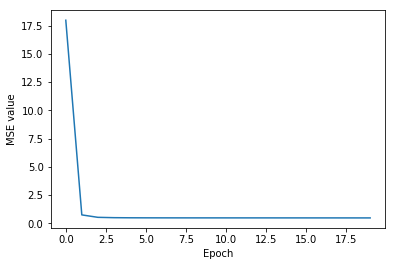

In [13]:
plt.plot(train_loss)
plt.xlabel("Epoch")
plt.ylabel("MSE value")
plt.show()